In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results_across_mice_c57.npy', allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [5]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='energy')

In [6]:
data_ncells = pd.read_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'_energy.csv')

# Apply task PLS for all areas and energy

In [7]:
%%bash
python area_pls.py -i results_pls/c57_n_cells.csv -o './results_pls/c57'

2023-04-28 11:55:21 PC1QFRRQ __main__[300603] INFO reading data...
2023-04-28 11:55:21 PC1QFRRQ __main__[300603] INFO computing PLS...
2023-04-28 11:55:21 PC1QFRRQ __main__[300603] INFO PLS computed, now performing bootstrap...
2023-04-28 11:55:21 PC1QFRRQ __main__[300603] INFO saving output data...


In [8]:
# %%bash
# python area_pls.py -i results_pls/c57_energy.csv -o './'

# Plot results

In [9]:
c57_contrasts = pd.read_csv('./results_pls/c57_contrasts.csv')
c57_saliences = pd.read_csv('./results_pls/c57_saliences.csv')
c57_contrasts = c57_contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

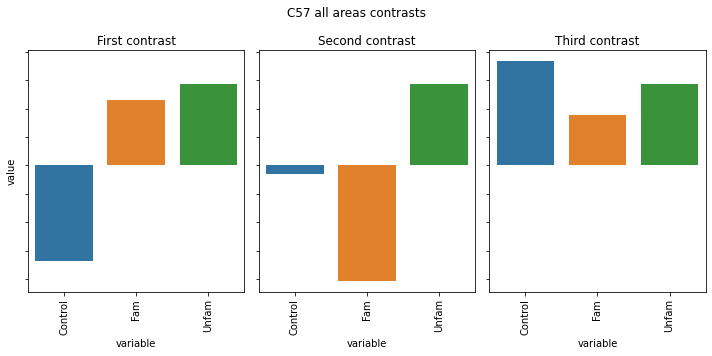

In [10]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.single_plot(df_data=c57_contrasts, index=0, ax=axes[0])
upls.single_plot(df_data=c57_contrasts, index=1, ax=axes[1])
upls.single_plot(df_data=c57_contrasts, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[1].set(yticklabels=[])
axes[2].set_ylabel('')
axes[2].set(yticklabels=[])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
fig.suptitle('C57 all areas contrasts')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_contrasts_all_areas.png')

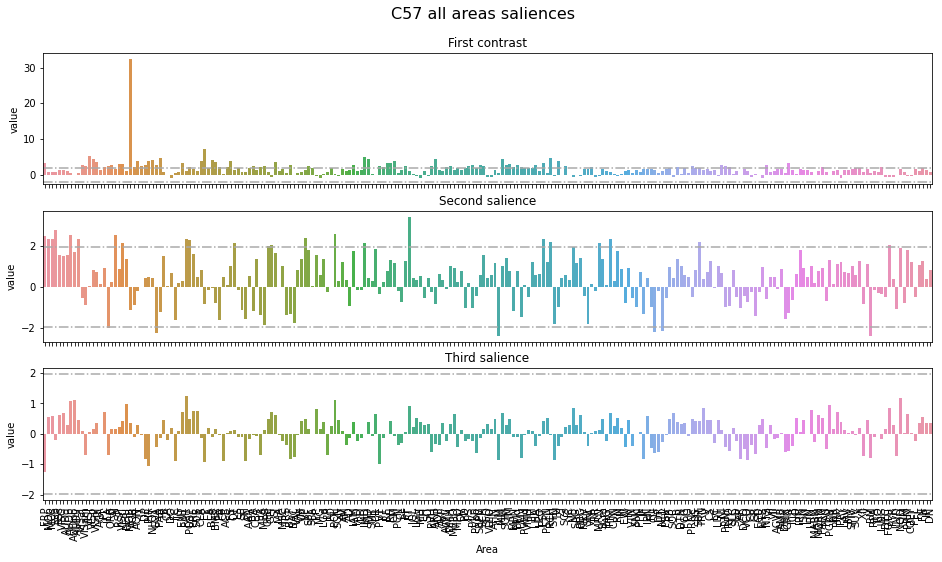

In [35]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=c57_saliences, index=0, ax=axes[0])
upls.single_plot(df_data=c57_saliences, index=1, ax=axes[1])
upls.single_plot(df_data=c57_saliences, index=2, ax=axes[2])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
# plt.tight_layout()
fig.suptitle('C57 - saliences for all areas', fontsize=16)
plt.savefig('./results_pls/c57_pls_saliences_all_areas.png')

In [52]:
c57_saliences.loc[0].max(), c57_saliences.idxmax(axis=1)

(32.34243789040861,
 0    MOB
 1     RT
 2    PAR
 dtype: object)

In [51]:
c57_saliences['MOB'].loc[0]

32.34243789040861

In [53]:
volumes.loc[volumes['acronym'] == 'MOB']['safe_name'].values[0]

'Main olfactory bulb'

# Identify areas with significant salience contribution

In [12]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=c57_saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)

In [21]:
pls_sig_areas

array(['Accessory olfactory bulb', 'Agranular insular area',
       'Anterior olfactory nucleus', 'Anterolateral visual area',
       'Anteromedial visual area',
       'Anteroventral periventricular nucleus',
       'Arcuate hypothalamic nucleus', "Barrington's nucleus",
       'Basolateral amygdalar nucleus', 'Basomedial amygdalar nucleus',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Central linear nucleus raphe',
       'Central medial nucleus of the thalamus', 'Claustrum',
       'Cortical amygdalar area', 'Dorsal peduncular area',
       'Dorsal premammillary nucleus',
       'Dorsomedial nucleus of the hypothalamus', 'Endopiriform nucleus',
       'Entorhinal area', 'Folium-tuber vermis (VII)',
       'Frontal pole cerebral cortex', 'Fundus of striatum',
       'Gigantocellular reticular nucleus',
       'Globus pallidus external segment',
       'Globus pallidus internal segment', 'Infralimbic area',
       'Interan

# Apply PLS for all significant areas in ncells and energy

In [14]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'_energy_filt.csv')

In [15]:
%%bash
python area_pls.py -i results_pls/c57_n_cells_filt.csv -o './results_pls/c57_filt'

2023-04-28 11:55:47 PC1QFRRQ __main__[300637] INFO reading data...
2023-04-28 11:55:47 PC1QFRRQ __main__[300637] INFO computing PLS...
2023-04-28 11:55:47 PC1QFRRQ __main__[300637] INFO PLS computed, now performing bootstrap...
2023-04-28 11:55:47 PC1QFRRQ __main__[300637] INFO saving output data...


In [16]:
%%bash
python area_pls.py -i results_pls/c57_energy_filt.csv -o './results_pls/c57_filt'

2023-04-28 11:55:49 PC1QFRRQ __main__[300642] INFO reading data...
2023-04-28 11:55:49 PC1QFRRQ __main__[300642] INFO computing PLS...
2023-04-28 11:55:49 PC1QFRRQ __main__[300642] INFO PLS computed, now performing bootstrap...
2023-04-28 11:55:50 PC1QFRRQ __main__[300642] INFO saving output data...


In [17]:
c57_contrasts_filt = pd.read_csv('./results_pls/c57_filt_contrasts.csv')
c57_saliences_filt = pd.read_csv('./results_pls/c57_filt_saliences.csv')
c57_contrasts_filt = c57_contrasts_filt.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

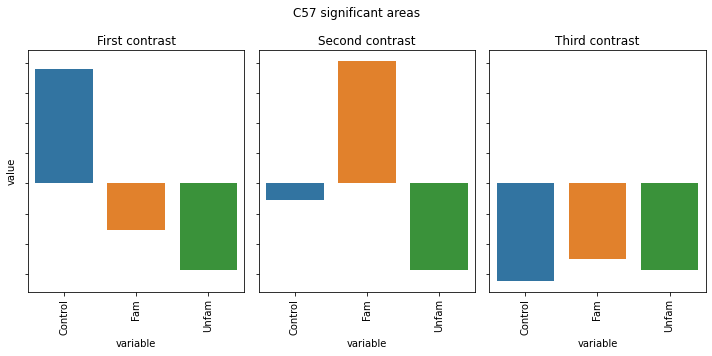

In [18]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.single_plot(df_data=c57_contrasts_filt, index=0, ax=axes[0])
upls.single_plot(df_data=c57_contrasts_filt, index=1, ax=axes[1])
upls.single_plot(df_data=c57_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[1].set(yticklabels=[])
axes[2].set_ylabel('')
axes[2].set(yticklabels=[])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
fig.suptitle('C57 significant areas')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_contrasts_sig_areas.png')

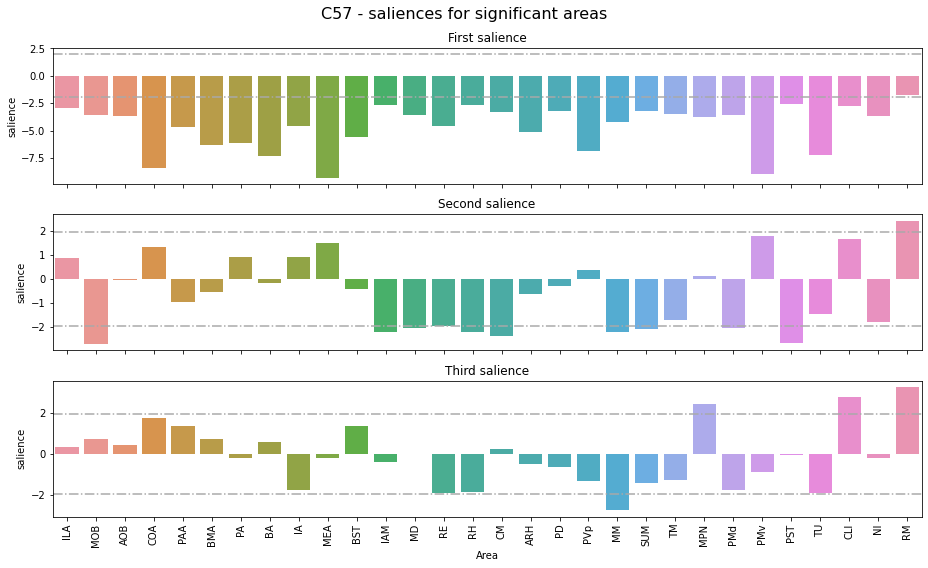

In [37]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=c57_saliences_filt, index=0, ax=axes[0])
upls.single_plot(df_data=c57_saliences_filt, index=1, ax=axes[1])
upls.single_plot(df_data=c57_saliences_filt, index=2, ax=axes[2])
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
fig.suptitle('C57 - saliences for significant areas', fontsize=16)
for i in range(3):
    axes[i].set_ylabel('salience')
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_saliences_sig_areas.png')

# Identify areas with significant salience contribution

In [20]:
pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=c57_saliences_filt, 
                                       threshold=1.96, 
                                       volumes=volumes)
pls_sig_areas_filt

array(['Accessory olfactory bulb', 'Arcuate hypothalamic nucleus',
       'Basomedial amygdalar nucleus',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Central linear nucleus raphe',
       'Central medial nucleus of the thalamus',
       'Cortical amygdalar area', 'Dorsal premammillary nucleus',
       'Infralimbic area', 'Interanteromedial nucleus of the thalamus',
       'Intercalated amygdalar nucleus', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Medial mammillary nucleus',
       'Medial preoptic nucleus', 'Mediodorsal nucleus of thalamus',
       'Nucleus incertus', 'Nucleus of reuniens', 'Nucleus raphe magnus',
       'Periventricular hypothalamic nucleus posterior part',
       'Piriform-amygdalar area', 'Posterior amygdalar nucleus',
       'Posterodorsal preoptic nucleus', 'Preparasubthalamic nucleus',
       'Rhomboid nucleus', 'Supramammillary nucleus', 'Tuberal nucleus',
       'Tuberomammillary n